In [ ]:
from nb_one_utils import *

In [ ]:
spark = configure_env()

Installing Java 8...
Java 8 Installed.
Installing pyspark and spark-nlp...
pyspark and spark-nlp installed.
Starting Spark runtime...
Spark NLP version:  2.4.2
Apache Spark version:  2.4.4
Spark is running.


In [ ]:
import re
from functools import partial
import numpy as np
import pandas as pd

import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

import nltk
download_nltk_dicts()
from nltk.corpus import stopwords

from wordcloud import WordCloud
import seaborn as sns


from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
wordnet and stopwords downloaded.


In [ ]:
meta = spark.read\
                .option("header", "true")\
                .csv("/content/abstract_data_final_00.csv")

In [ ]:
meta.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- cord_uid: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- title: string (nullable = true)
 |-- license: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- publish_year: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- url: string (nullable = true)
 |-- word_count: string (nullable = true)



In [ ]:
meta = meta.drop("_c0")

In [ ]:
abstracts = meta.rdd.map(lambda x : x['abstract']).collect()

In [ ]:
stop_words = set(stopwords.words("english"))

In [ ]:
freq = pd.Series(' '.join(abstracts).lower().split()).value_counts()[:25]
freq = dict(freq)
freq = list(freq.keys())
freq

['the',
 'of',
 'and',
 'in',
 'to',
 'a',
 'with',
 'for',
 'was',
 'were',
 'is',
 'that',
 'by',
 'as',
 'this',
 'on',
 'we',
 'from',
 'patients',
 'are',
 'be',
 'an',
 'or',
 'at',
 'have']

In [ ]:
freq.remove("patients")
print(len(freq))

In [ ]:
stop_words = stop_words.union(set(freq))
freq_upper = [x.capitalize() for x in stop_words]
stop_words = stop_words.union(set(freq_upper))

In [ ]:
curried_stop_word_cleaner = partial(remove_stop_words, stop_words=stop_words)
udfStopWordCleaner = udf(curried_stop_word_cleaner, StringType())
meta = meta.withColumn('raw_abstract', udfStopWordCleaner('abstract'))
meta.select('raw_abstract').show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
abstracts[11]

'A remarkable collaborative effort coordinated by the severe acute respiratory syndrome (SARS) team at WHO resulted in discovery of the etiologic agent of severe acute respiratory syndrome less than 2 months after the announcement of global alert. The development of a vaccine to prevent SARS should be pursued with the same urgency and cooperative spirit, as SARS is highly lethal and, if not controlled during the first few generations of transmission, is likely to become endemic in regions of the world where health-care infrastructure is underdeveloped and epidemiological control measures are weak. The scientific community already learned many important lessons from HIV vaccine development; these should be heeded. For example, consideration should be given to the development of a vaccine that will protect across regional strains of SARS, as the newly emergent coronavirus SARS-coronavirus (SARS-CoV) is proving to be variable and may be mutating in response to immune pressure. SARS-specif

In [ ]:
corpus = meta.rdd.map(lambda x : x['raw_abstract']).collect()

In [ ]:
corpus[11]

'remarkable collaborative effort coordinated severe acute respiratory syndrome SARS team WHO resulted discovery etiologic agent severe acute respiratory syndrome less months announcement global alert. development vaccine prevent SARS pursued urgency cooperative spirit, SARS highly lethal and, controlled first generations transmission, likely become endemic regions world healthcare infrastructure underdeveloped epidemiological control measures weak. scientific community already learned many important lessons HIV vaccine development; heeded. example, consideration given development vaccine protect across regional strains SARS, newly emergent coronavirus SARScoronavirus SARSCoV proving variable may mutating response immune pressure. SARSspecific research reagents also collected shared. would include SARS peptides, adjuvants, DNA vaccine vectors clinical grade viral vectors. Rapidly developing collaborative approach developing SARS vaccine effective safe way go. article reviews parallels H

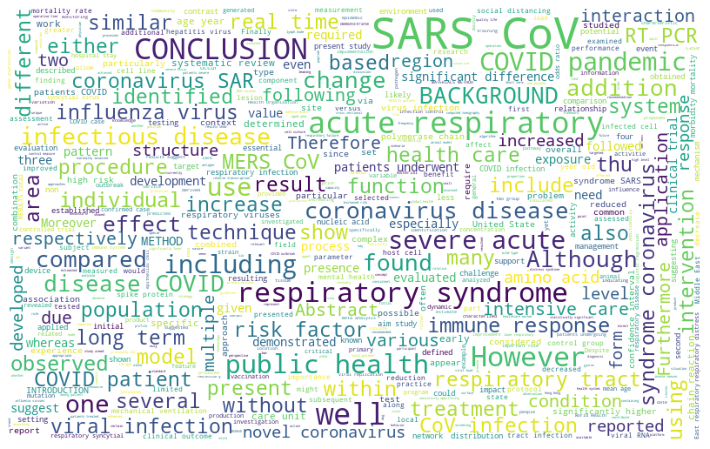

In [ ]:
%matplotlib inline
visualize_wordcloud(abstracts, "corpus_cloud.png", stop_words) 

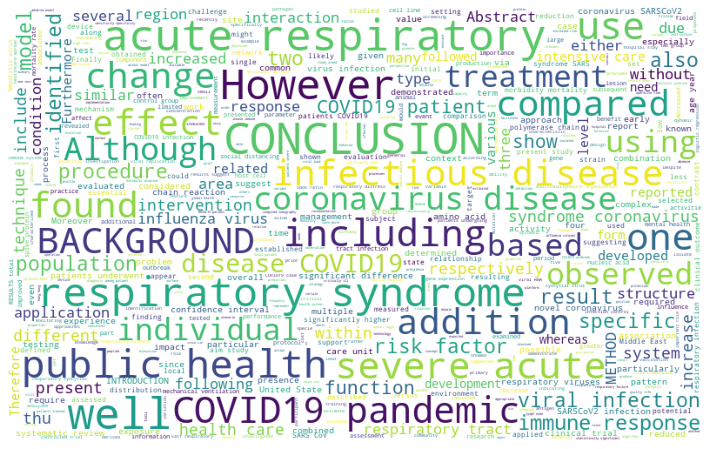

In [ ]:
visualize_wordcloud(corpus, "raw_corpus_cloud.png", stop_words) 

## Keywords

In [ ]:
abstracts[444]

'The present ongoing global pandemic caused by SARS-CoV-2 virus is creating havoc across the world. The absence of any vaccine as well as any definitive drug to cure, has made the situation very grave. Therefore only few effective tools are available to contain the rapid pace of spread of this disease, named as COVID-19. On 24th March, 2020, the the Union Government of India made an announcement of unprecedented complete lockdown of the entire country effective from the next day. No exercise of similar scale and magnitude has been ever undertaken anywhere on the globe in the history of entire mankind. This study aims to scientifically analyze the implications of this decision using a kinetic model covering more than 96% of Indian territory. This model was further constrained by large sets of realistic parameters pertinent to India in order to capture the ground realities prevailing in India, such as: (i) true state wise population density distribution, (ii) accurate state wise infectio

In [ ]:
sample = corpus[444]
print("Top keywords in sample: ", [x for x in (get_keywords(sample, n=3))])

Top keywords in sample:  ['model', 'lockdown', 'different']


In [ ]:
getKeywords = udf(get_keywords, ArrayType(StringType()))
meta = meta.withColumn("keywords", getKeywords("raw_abstract"))

In [ ]:
meta.select("title", "keywords").show(15, truncate=True)

+--------------------+--------------------+
|               title|            keywords|
+--------------------+--------------------+
|Testing the modul...|[rna, nterminal, ...|
|Activation of Egr...|[egr1, tat, expre...|
|Dissolution Advan...|[dissolution, ntz...|
|Thin-section comp...|[ct, patients, ad...|
|Conducting polyme...|[polymeric, based...|
|Haploidentical St...|[children, transp...|
|Chapter 12 Corona...|[coronaviruses, p...|
|Switch from Cap- ...|[translation, igr...|
|Antiviral activit...|[chikv, virus, ni...|
|Identification of...|[sma, cns, splice...|
|Vaccines for emer...|[health, emerging...|
|How the SARS vacc...|[sars, vaccine, d...|
|The Experience of...|[nurses, feeling,...|
|Detection of Alph...|[bat, bats, molos...|
|LncRNA CTBP1-AS2 ...|[ctbp1as2, mir130...|
+--------------------+--------------------+
only showing top 15 rows



In [ ]:
import pickle
with open('stop_words.pkl', 'wb') as f1:
    pickle.dump(stop_words, f1)

In [ ]:
with open('open_covid_corpus.pkl', 'wb') as f3:
    pickle.dump(corpus, f3)

In [ ]:
meta.toPandas().to_csv('abstract_data_final_01.csv')